In [96]:
import numpy as np
import numba as nb
from scipy import stats
from scipy import ndimage
from scipy import signal

import cv2
from matplotlib import pyplot as plt

# Image Grid System
This shows how the gird system starts at the top-left corner. We can also see that the <b style="color: green">first coordinate is represented by the $y$-axis (height)</b> and the <b style="color: red">second coordinate is represented by the $x$-axis (width)</b> of the image.

In [2]:
cross_im = np.zeros((10, 10))
cross_im[2,:] = 255
cross_im[:,6] = 255
cross_im

array([[  0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.],
       [255., 255., 255., 255., 255., 255., 255., 255., 255., 255.],
       [  0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.]])

Here we build this (10x10) image of a white cross on black background. We set the pixels on the second row (second height level $y=2$) to white. We also set the pixels on the fith column (fifth width level $x=5$) to white. Then we plot the image to show the result

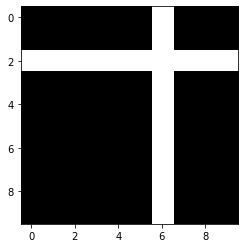

In [3]:
plt.imshow(cross_im, cmap='gray')

# Cross-correlation & Convolution
Cross-Correlation:
$$(\psi \circ f)(x)=\sum_{k = -\infty}^{+\infty}{\psi (i) f(x + k)}$$
Convolution:
$$(\psi \circ f)(x)=\sum_{k = -\infty}^{+\infty}{\psi (i) f(x - k)}$$
First we define few very simple kernels:

In [119]:
simple_kernel = np.arange(1, 10).reshape(3, 3)
avg_kernel = np.ones((3, 3)) / 9
gaus_kernel = np.array([
    [0.1, 0.2, 0.1],
    [0.2, 0.3, 0.2],
    [0.1, 0.2, 0.1]
])

gaus_kernel_1d = np.array([1, 2, 1]) / 4

## Cross-Correlation Implementation Example
We define our own very simple `cross-correlation` procedure and we compare it to the one defined in `scipy.signal`

In [97]:
def cross_correlate(im, kernel):
    m1, m2 = im.shape
    k1, k2 = kernel.shape
    a1 = (k1 - 1) / 2
    a2 = (k2 - 1) / 2
    m = m1 * m2
    
    im_arr = im.reshape(-1, 1)
    W = np.zeros((m, m))
    
    W_is = np.zeros((k1, m2, m2))
    
    for ik1 in range(k1):
        for im2 in range(m2):
            k_start = 0
            k_end = a2 * 2 + 1
            start = im2 - a2
            end = im2 + a2 + 1
            if start < 0:
                k_start = k_start - start
                start = 0
            if end > m2:
                diff = end - (m2)
                k_end = k_end - diff
                end = m2
            
            k_start = int(k_start)
            k_end = int(k_end)
            start = int(start)
            end = int(end)
            k_vals = kernel[ik1, k_start:k_end]
            W_is [ik1, im2, start:end] = k_vals
            
    for im1 in range(m1):
        k_start = -a1
        k_end = a1 + 1
        start = im1 - a1
        end = im1 + a1 + 1
        
        if start < 0:
            k_start = k_start - start
            start = 0
            
        if end > m1:
                diff = end - (m1)
                k_end = k_end - diff
                end = m2
                
        k_start = int(k_start)
        k_end = int(k_end)
        for ik1 in range(k_start, k_end):
            start_y = m2 * (im1 + ik1)
            end_y = m2 * (im1 + ik1 + 1)
            start_x = m2 * (im1)
            end_x = m2 * (im1 + 1)
            W[start_x:end_x, start_y:end_y] = W_is[int(ik1 + a1)]
        
    
    return (W @ im_arr).reshape(m1, m2)

We can observe that we have the same result from both procedures but the scipy implementation is way faster.

CPU times: user 712 µs, sys: 345 µs, total: 1.06 ms
Wall time: 385 µs
CPU times: user 196 µs, sys: 95 µs, total: 291 µs
Wall time: 49.4 µs
CPU times: user 1.61 ms, sys: 4.84 ms, total: 6.46 ms
Wall time: 1.09 ms
CPU times: user 0 ns, sys: 980 µs, total: 980 µs
Wall time: 149 µs


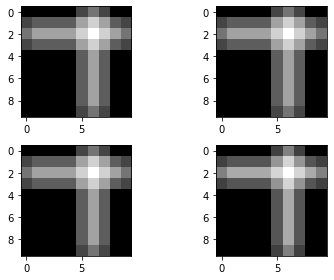

In [126]:
def correlate_2x1d(im, kernel):
    cross_im_cor = ndimage.correlate1d(im, kernel, mode='constant', axis=0)
    return ndimage.correlate1d(cross_im_cor, kernel, mode='constant', axis=1)

%time cross_im_corr = cross_correlate(cross_im, gaus_kernel)
%time cross_im_corr1 = signal.correlate2d(cross_im, gaus_kernel, mode='same')
%time cross_im_corr2 = ndimage.correlate(cross_im, gaus_kernel, mode='constant')
%time cross_im_corr3 = correlate_2x1d(cross_im, gaus_kernel_1d)

fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].imshow(cross_im_corr, cmap='gray')
axes[0, 1].imshow(cross_im_corr1, cmap='gray')
axes[1, 0].imshow(cross_im_corr2, cmap='gray')
axes[1, 1].imshow(cross_im_corr3, cmap='gray')
plt.tight_layout()

## Implementation Comparisons


### Numpy works only with 1-D arrays
Cross-Correlation & Convolution work only with 1-D arrays
```
Help on function convolve in module numpy:

convolve(a, v, mode='full')
    Returns the discrete, linear convolution of two one-dimensional sequences.
```

Symetric Kernel: Correlation == Convolution: True
Non-Symetric Kernel: Correlation == Convolution: False


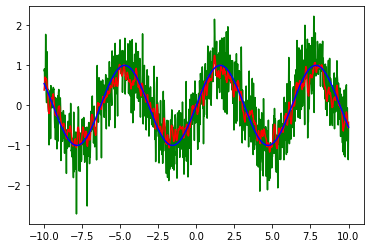

In [81]:
def f1D(x):
    return np.sin(x)

gaussKernel = stats.norm.pdf(np.arange(-3, 4), scale=2.5)
simpleKernel = np.array([1, 2, 3, 4, 5]) / 15


x = np.linspace(-10, 10, 1000)
err = np.random.normal(0, 0.5, 1000)
y = f1D(x)
y_err = y + err
y_conv = np.convolve(y_err, gaussKernel, mode='same')
y_corr = np.correlate(y_err, gaussKernel, mode='same')

plt.plot(x, y_err, '-g')
plt.plot(x, y_corr, '-r', label='line 2')
plt.plot(x, y, '-b', label='line 1')


print("Symetric Kernel: Correlation == Convolution:", np.all(y_corr == y_conv))
print("Non-Symetric Kernel: Correlation == Convolution:", np.all(np.correlate(y_err, simpleKernel, mode='same') == np.convolve(y_err, simpleKernel, mode='same')))

### N-D Arrays (SciPy and OpenCV)

CPU times: user 21.6 ms, sys: 0 ns, total: 21.6 ms
Wall time: 21.7 ms
CPU times: user 23.6 ms, sys: 0 ns, total: 23.6 ms
Wall time: 23.9 ms
CPU times: user 2.68 ms, sys: 0 ns, total: 2.68 ms
Wall time: 2.5 ms
CPU times: user 902 µs, sys: 0 ns, total: 902 µs
Wall time: 616 µs


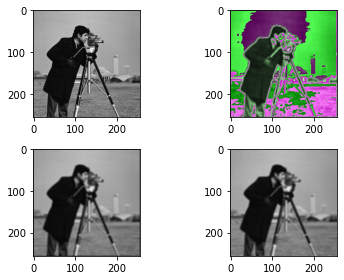

In [230]:
im = cv2.imread('./images/contrast/camerman1.png')
avg_kernel = np.ones((5, 5, 3), np.float32) / 25
avg_kernel2 = np.ones((5, 5), np.float32) / 25
avg_kernel_1d = np.ones((5), np.float32) / 5

%time im_sign = signal.convolve(im, avg_kernel, mode='same')
%time im_ndim = ndimage.convolve(im, avg_kernel, mode='constant')
%time im_ndim1d = correlate_2x1d(im, avg_kernel_1d)
%time im_cv = cv2.filter2D(im, -1, avg_kernel2)

fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].imshow(im)
axes[0, 1].imshow(im_ndim)
axes[1, 0].imshow(im_ndim1d)
axes[1, 1].imshow(im_cv)
plt.tight_layout()

# MeshGrid
## Indexing
Cartesian vs Matrix indexing:

In the 3-D case with inputs of length M, N and P, outputs are of shape (N, M, P) for ‘xy’ (Cartesian) indexing and (M, N, P) for ‘ij’ (Matrix) indexing. The default is 

In [227]:
%time print("Cartesian:", np.meshgrid(np.arange(4), np.arange(3)))
%time print("Matrix:", np.meshgrid(np.arange(4), np.arange(3), indexing='ij'))

Cartesian: [array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]]), array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2]])]
CPU times: user 2.02 ms, sys: 0 ns, total: 2.02 ms
Wall time: 1.33 ms
Matrix: [array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]]), array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])]
CPU times: user 933 µs, sys: 332 µs, total: 1.27 ms
Wall time: 691 µs


## `mgrid`
nd_grid instance which returns a dense multi-dimensional “meshgrid”. The `mgrid` is always given in Matrix indexing. Range vs Linear Space:

In [228]:
%time print("Range:", np.mgrid[0:4:1, 0:3:1])
%time print("Linear Space:", np.mgrid[0:1:2j, 0:1:3j])

Range: [[[0 0 0]
  [1 1 1]
  [2 2 2]
  [3 3 3]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]
  [0 1 2]]]
CPU times: user 4.01 ms, sys: 1.76 ms, total: 5.77 ms
Wall time: 3.67 ms
Linear Space: [[[0.  0.  0. ]
  [1.  1.  1. ]]

 [[0.  0.5 1. ]
  [0.  0.5 1. ]]]
CPU times: user 2.69 ms, sys: 850 µs, total: 3.54 ms
Wall time: 2.88 ms


## `ogrid`
nd_grid instance which returns an open multi-dimensional “meshgrid”. The `ogrid` is always given in Matrix indexing.

In [233]:
np.ogrid[0:3,0:4]

[array([[0],
        [1],
        [2]]),
 array([[0, 1, 2, 3]])]

## Example with Meshgrid

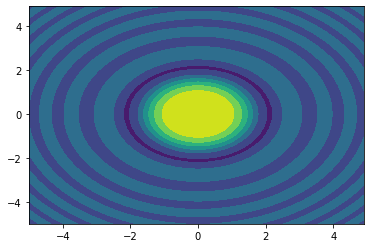

In [229]:
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)

xx, yy = np.meshgrid(x, y, sparse=True)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)

h = plt.contourf(x,y,z)
plt.show()

# Interpolation

## 1-D Interpolation with Numpy

```
    interp(x, xp, fp, left=None, right=None, period=None)
    One-dimensional linear interpolation.
    
    Returns the one-dimensional piecewise linear interpolant to a function
    with given discrete data points (`xp`, `fp`), evaluated at `x`.
```

### Example: $\sin(x)$
As data points we have 10 points `(xp, yp)` on the interval $(0, 2 \pi)$ (blue dots). Then we interpolate 50 points on that same interval (orange x)

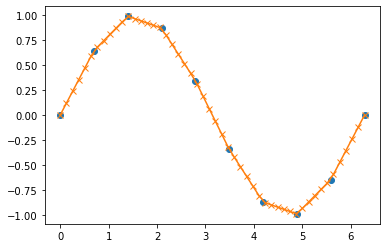

In [240]:
# Data points
xp = np.linspace(0, 2*np.pi, 10)
yp = np.sin(xp)

# Target points for interpolation
x = np.linspace(0, 2*np.pi, 50)
yinterp = np.interp(x, xp, yp)

plt.plot(xp, yp, 'o')
plt.plot(x, yinterp, '-x')
plt.show()